In [4]:
import matlab.engine

In [5]:
eng = matlab.engine.start_matlab()

In [6]:
import numpy as np
from scipy import fftpack
import tensorly as tl 
import time
from tensorly.decomposition import tucker
import tensorsketch
from tensorsketch import util
from tensorsketch.util import square_tensor_gen
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle 
import simulation
plt.style.use('seaborn-paper')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import scipy.io
from brokenaxes import brokenaxes

Using numpy backend.
Using numpy backend.


In [7]:
def sim_name(gen_type,r,noise_level,dim, rm_typ): 
    """
    Obtain the file name to use for a given simulation setting
    """
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)+ "_" + rm_typ
def find_rm_label(rm_typ): 
    if rm_typ == "g": 
        return "Gaussian"
    elif rm_typ == "u":
        return "Uniform"
    elif rm_typ == "sp0":
        return "Sparse"
    elif rm_typ == "gprod":
        return "Gaussian TRP"
    elif rm_typ == "ssrft":
        return "SSRFT"
    elif rm_typ == "sp0prod": 
        return "Sparse TRP"
def find_gen_label(gen_typ): 
    if gen_typ == "id": 
        return "Superdiagonal"
    elif gen_typ == "lk":
        return "Low Rank"
    elif gen_typ == "fed":
        return "Fast Exponential Decay"
    elif gen_typ == "sed": 
        return "Slow Exponential Decay"
    elif gen_typ == "fpd": 
        return "Fast Polynomial Decay"
    elif gen_typ == "spd": 
        return "Polynomial Decay"
    elif gen_typ == "slk":
        return "Sparse Low Rank"

In [8]:
MARKER_LIST = ["s", "x", "o","+","*","d","^","v"]
MARKER_COLOR_LIST = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lawngreen','violet']

In [9]:
def marker_color(method, rm_typ = 'gprod'): 
    pairs = [('TS','gprod'),('2pass','gprod'),('1pass','gprod'),('1pass','sp0prod'),('1pass','ssrft'),('1pass','gprod'),('2pass','gprod'),('1pass','g')] 
    if (method, rm_typ) in pairs:
        return MARKER_COLOR_LIST[pairs.index((method, rm_typ))]
    else: 
        return np.random.rand(3,1)  
def marker(method, rm_typ = 'gprod'): 
    pairs = [('TS','gprod'),('2pass','gprod'),('1pass','gprod'),('1pass','sp0prod'),('1pass','ssrft'),('1pass','gprod'),('2pass','gprod'),('1pass', 'g')] 
    if (method, rm_typ) in pairs:
        return MARKER_LIST[pairs.index((method, rm_typ))]
    else: 
        return 's'
def set_plot(fontsize): 




In [10]:
def gen_sparse_ten(n,nnz,r, dim = 3,noise_level = 1e-3):
    density = (1 - (1 - nnz**(1/dim)/n)**(1/r))*r
    core_tensor = np.random.normal(0,1,[r for _ in range(dim)])
    arms = []
    tensor = core_tensor
    for i in np.arange(dim): 
        arm =  np.random.normal(0,1,size = (n,r))
        arm = arm*np.random.binomial(1,density,size=(n,r))
        arms.append(arm)
        tensor = tl.tenalg.mode_dot(tensor, arm, mode=i) 
    tensor0 = tensor
    tensor = tensor + np.random.normal(0,1,size = [n for _ in range(dim)])*noise_level
    return tensor, tensor0 

In [11]:
def avg_sim_list(sim_list): 
    sim_list_new = []
    for sims in sim_list: 
        sim_list_new.append(np.mean(sims, axis = 0)) 
    return sim_list_new

In [12]:
def TS_mem_cost(K,r = 10,dim = 3): 
    return K*r**(2*dim-2) + K*r**(2*dim)
def one_pass_mem_cost(k,dim = 3,n = 300):
    return k*dim*n + (2*k+1)**dim

In [13]:
sim_fig1_lk_lnoise = pickle.load(open("data/sim_fig1_lk_lnoise" +".pickle", "rb"))
sim_fig1_lk_mnoise = pickle.load(open("data/sim_fig1_lk_mnoise" +".pickle", "rb"))
sim_fig1_lk_hnoise = pickle.load(open("data/sim_fig1_lk_hnoise" +".pickle", "rb"))
sim_fig1_slk_lnoise = pickle.load(open("data/sim_fig1_slk_lnoise" +".pickle", "rb"))
sim_fig1_slk_mnoise = pickle.load(open("data/sim_fig1_slk_mnoise" +".pickle", "rb"))
sim_fig1_slk_hnoise = pickle.load(open("data/sim_fig1_slk_hnoise" +".pickle", "rb"))
sim_fig1_spd = pickle.load(open("data/sim_fig1_spd" +".pickle", "rb"))
sim_fig1_fpd = pickle.load(open("data/sim_fig1_fpd" +".pickle", "rb"))
#sim_fig1_sed = pickle.load(open("data/sim_fig1_sed" +".pickle", "rb"))
#sim_fig1_fed = pickle.load(open("data/sim_fig1_fed" +".pickle", "rb"))

sim_fig1_slk = pickle.load(open("data/fig1_slk" +".pickle", "rb"))
sim_fig1_lk_ext = pickle.load(open("data/fig1_lk_ext" +".pickle", "rb"))
sim_fig1_spd_ext = pickle.load(open("data/fig1_spd_ext" +".pickle", "rb"))
sim_fig1_slk_ext = pickle.load(open("data/fig1_slk_ext" +".pickle", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/sim_fig1_lk_lnoise.pickle'

In [11]:
TS_mem_cost(100, 10,3)

101000000

In [14]:
one_pass_mem_cost(20,dim = 3,n = 2200)

200921

In [15]:
101000000/200921

502.685134953539

In [16]:
one_pass_mem_cost(300,dim = 3,n = 2200)

219061801

In [17]:
101000000/219061801

0.46105710598079125

In [10]:
def mem_to_K(mem, r = 10, dim = 3): 
# Here, we do not set K to be integer, since K is just a constant, and we only need J1,J2 to be integer
    return (mem/r**(2*dim -2)/(r**2+1))

In [11]:
def fig1_reprun(gen_type,ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    ss = 2*ks+1
    Ks = np.array([mem_to_K(one_pass_mem_cost(k, dim, n),r,dim) for k in ks])
    J1s = (Ks*r**(dim-1)).astype(int)
    J2s = (Ks*r**dim).astype(int)
    
    hooi_rerr = np.zeros((sim_runs, len(ks)))
    two_pass_rerr = np.zeros((sim_runs,len(ks)))
    one_pass_rerr = np.zeros((sim_runs,len(ks)))
    als_rerr = np.zeros((sim_runs, len(ks)))
    ts_rerr = np.zeros((sim_runs, len(ks)))
    ttmts_rerr = np.zeros((sim_runs, len(ks)))
    
    # Since r is not updated, the result for ALS is only needed once.
    Y = square_tensor_gen(n, r0, dim = dim, typ = gen_type, noise_level = noise_level, seed = random_seed)[0]
    Ymatlab = matlab.double(Y.tolist())
    rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
    for i in range(sim_runs): 
        for idx, k in enumerate(ks): 
            k = ks[idx]
            s = ss[idx]            
            tapprox = tensorsketch.tensor_approx.TensorApprox( Y, [r for _ in range(dim)], ks = [k for _ in range(dim)], \
                ss = [s for _ in range(dim)], random_seed = 1, rm_typ = rm_typ, store_phis = True) 
            Y_hat_hooi, _, _, _, (_, recover_time) = tapprox.tensor_approx('hooi')
            if s > n: 
                rerr_onepass = one_pass_rerr[i,idx-1]
            else:
                Y_hat_onepass, _, _, _, (_, recover_time) = tapprox.tensor_approx('onepass')
                rerr_onepass = tensorsketch.util.eval_rerr(Y,Y_hat_onepass,Y)  
            if k > n:  
                rerr_twopass = two_pass_rerr[i,idx-1]
            else: 
                Y_hat_twopass, _, _, _, (_, recover_time) = tapprox.tensor_approx('twopass')
                rerr_twopass = tensorsketch.util.eval_rerr(Y,Y_hat_twopass,Y)
            rerr_hooi = tensorsketch.util.eval_rerr(Y,Y_hat_hooi,Y)
            hooi_rerr[i,idx] = rerr_hooi
            two_pass_rerr[i,idx] = rerr_twopass
            one_pass_rerr[i,idx] = rerr_onepass
            print(rerr_twopass)
            print(rerr_onepass)
            J1 = matlab.int64([J1s[idx]])
            J2 = matlab.int64([J2s[idx]])
            if (J1s[idx] < n**(dim-1)) & (J2s[idx] < n**dim): 
                rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            else: 
                rerr_ts = ts_rerr[i,idx-1]
            rerr_ttmts = 0
            # rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            # Sometimes, there are errors
            assert(rerr_als - rerr_hooi < 0.001)
            als_rerr[i,idx] = rerr_als 
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
    sim_list = [hooi_rerr, two_pass_rerr,one_pass_rerr, ts_rerr, ttmts_rerr, als_rerr]
    if gen_type in ['lk', 'slk']: 
        if noise_level == 0.01: 
            noise_str = "lnoise"
        elif noise_level == 0.1: 
            noise_str = "mnoise"
        elif noise_level == 1:
            noise_str = "hnoise"
        pickle.dump(sim_list, open("data/sim_fig1_"+gen_type+"_" +noise_str+".pickle", "wb" ) )
    else: 
        pickle.dump(sim_list, open("data/sim_fig1_"+gen_type+".pickle", "wb" ) )
    return sim_list

In [12]:
r = 10; dim = 3; kmin = 12; kmax = 115
Kmin = kmin*300/r**(dim-1)
ks = (np.exp(np.linspace(np.log(kmin), np.log(kmax),10))).astype(int)

In [30]:
sim_fig1_lk_lnoise =fig1_reprun('lk',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") 
sim_fig1_lk_mnoise =fig1_reprun('lk',ks = ks, r0 =10, r = 10, noise_level = 0.1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") 
sim_fig1_lk_hnoise =fig1_reprun('lk',ks = ks, r0 =10, r = 10, noise_level = 1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") 

sim_fig1_slk_lnoise =fig1_reprun('slk',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_slk_mnoise =fig1_reprun('slk',ks = ks, r0 =10, r = 10, noise_level = 0.1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_slk_hnoise =fig1_reprun('slk',ks = ks, r0 =10, r = 10, noise_level = 1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")

sim_fig1_spd =fig1_reprun('spd',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_fpd =fig1_reprun('fpd',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_fed =fig1_reprun('fed',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_sed =fig1_reprun('sed',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")


NameError: name 'ks' is not defined

In [161]:
'''
def fig1_repplot0(sim_list,ks,name, gen_type = 'slk',noise_level= 0.01,n = 300, r = 10, dim = 3,fontsize = 18, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
            
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    
    if outside: 
        plt.figure(figsize=(10,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    
    hooi_result = np.log(sim_list[0])
    two_pass_result = np.log(sim_list[1]) #/sim_list[0])
    one_pass_result =  np.log(sim_list[2]) #/sim_list[0])
    ts_result =  np.log(sim_list[3]) #/sim_list[0])
    ttmts_result =  np.log(sim_list[4]) #/sim_list[0])
    als_result = np.log(sim_list[5])
    
    ss = 2*ks+1
    Ks = np.array([mem_to_K(one_pass_mem_cost(k, dim, n),r,dim) for k in ks])
    J1s = (Ks*r**(dim-1)).astype(int)
    J2s = (Ks*r**dim).astype(int)
    
    mem1 = np.log((2*ks + 1)**dim + dim*ks*n) 
    mem2 = np.log(J2s*(r**dim) + J1s*(r**(dim-1)))

    
    plt.plot(mem1, als_result, label = 'HOOI', markersize = 10, marker = MARKER_LIST[0], color = MARKER_COLOR_LIST[0], markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem1, two_pass_result, label = 'Two Pass', markersize = 10, marker = MARKER_LIST[1], color = MARKER_COLOR_LIST[1], markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem1, one_pass_result, label = 'One Pass', markersize = 10, marker = MARKER_LIST[2], color = MARKER_COLOR_LIST[2], markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem2, ts_result, label = 'TS', markersize = 10, marker = MARKER_LIST[3], color = MARKER_COLOR_LIST[3], markeredgewidth=1, markerfacecolor='None')
    
    plt.xlabel('Log(Memory Use)', ha='center',fontsize =fontsize)
    if noise_level == 0.01: 
        noise_str = "lnoise"
    elif noise_level == 0.1: 
        noise_str = "mnoise"
    elif noise_level == 1:
        noise_str = "hnoise"
    if gen_type in ['lk','slk']:
        plt.title("Vary Memory Size, I = %s"%(n)+" ("+find_gen_label(gen_type)+" $\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title("Vary k, I = %s"%(n)+" ("+find_gen_label(gen_type)+")", fontsize = fontsize)

    plt.ylabel('Log(Relative Error)', fontsize = fontsize)
    plt.xticks(fontsize =fontsize)
    plt.yticks(fontsize = fontsize)
    plt.rcParams.update({'font.size':fontsize})
    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1.55, 0.85))
    plt.tight_layout()
    plt.savefig('plots/journal/'+name, bbox_inches = 'tight')
    plt.show()
'''

IndentationError: unexpected indent (<ipython-input-161-4e0d9cd74b8c>, line 4)

In [2]:
def fig1_repplot0(sim_list,ks,name, gen_type = 'slk',noise_level= 0.01,n = 300, r = 10, dim = 3,fontsize = 18, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
            
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    
    if outside: 
        plt.figure(figsize=(10,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    
    hooi_result = sim_list[0]
    two_pass_result = (sim_list[1]) #/sim_list[0])
    one_pass_result = (sim_list[2]) #/sim_list[0])
    ts_result = (sim_list[3]) #/sim_list[0])
    ttmts_result = (sim_list[4]) #/sim_list[0])
    als_result =(sim_list[5])
    
    ss = 2*ks+1
    Ks = np.array([mem_to_K(one_pass_mem_cost(k, dim, n),r,dim) for k in ks])
    J1s = (Ks*r**(dim-1)).astype(int)
    J2s = (Ks*r**dim).astype(int)
    
    mem1 = ((2*ks + 1)**dim + dim*ks*n) 
    mem2 = (J2s*(r**dim) + J1s*(r**(dim-1)))

    plt.plot(mem1, np.array(two_pass_result)-np.array(als_result), label = 'Two Pass', markersize = 10, marker = marker('2pass', 'gprod'), color = marker_color('2pass', 'gprod'), markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem1, np.array(one_pass_result)-np.array(als_result), label = 'One Pass', markersize = 10, marker = marker('1pass', 'gprod'), color = marker_color('1pass', 'gprod'), markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem2, np.array(ts_result)-np.array(als_result), label = 'TS', markersize = 10, marker = marker('TS', 'gprod'), color = marker_color('TS', 'gprod'),  markeredgewidth=1, markerfacecolor='None')

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Memory Use', ha='center',fontsize =fontsize)
    if noise_level == 0.01: 
        noise_str = "lnoise"
    elif noise_level == 0.1: 
        noise_str = "mnoise"
    elif noise_level == 1:
        noise_str = "hnoise"
    if gen_type in ['lk','slk']:
        plt.title("I = %s"%(n)+" ("+find_gen_label(gen_type)+" $\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title(" ("+find_gen_label(gen_type)+")", fontsize = fontsize)

    plt.ylabel('Regret', fontsize = fontsize)
    plt.xticks(fontsize =fontsize)
    plt.yticks(fontsize = fontsize)
    
    # plt.axvline(x = one_pass_mem_cost(k = 2*r, dim = 3, n=n), color = marker_color('1pass','gprod'))
    # plt.axvline(x = TS_mem_cost(K = 10, r =r, dim = 3), color = marker_color('TS', 'gprod'),)
    plt.rcParams.update({'font.size':fontsize})
    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1.55, 0.85))
    plt.tight_layout()
    plt.savefig('plots/journal/'+name, bbox_inches = 'tight')
    plt.show()
    

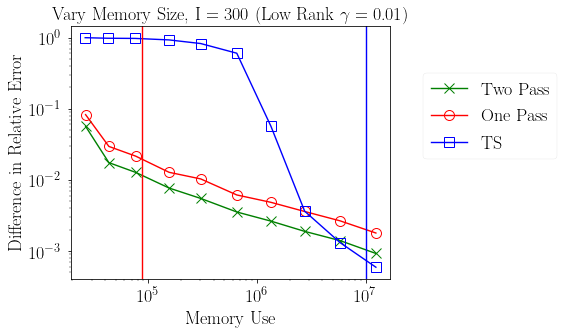

In [33]:
fig1_repplot0(avg_sim_list(sim_fig1_lk_lnoise), ks = ks, gen_type = 'lk', noise_level = 0.01, name = 'fig1_lk_lnoise.pdf',n =300, outside= True)


In [3]:
fig1_repplot0(avg_sim_list(sim_fig1_lk_lnoise), ks = ks, gen_type = 'lk', noise_level = 0.01, name = 'fig1_lk_lnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_lk_mnoise), ks = ks, gen_type = 'lk', noise_level = 0.1, name = 'fig1_lk_mnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_lk_hnoise), ks = ks, gen_type = 'lk', noise_level = 1, name = 'fig1_lk_hnoise.pdf',n =300, outside = True)


fig1_repplot0(avg_sim_list(sim_fig1_slk_lnoise), ks = ks, gen_type = 'slk', noise_level = 0.01, name = 'fig1_slk_lnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_slk_mnoise), ks = ks, gen_type = 'slk', noise_level = 0.1, name = 'fig1_slk_mnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_slk_hnoise), ks = ks, gen_type = 'slk', noise_level = 1, name = 'fig1_slk_hnoise.pdf',n =300)


fig1_repplot0(avg_sim_list(sim_fig1_spd), ks = ks, gen_type = 'spd', name = 'fig1_spd.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_fpd), ks = ks, gen_type = 'fpd', name = 'fig1_fpd.pdf',n =300)
#fig1_repplot0(avg_sim_list(sim_fig1_sed), ks = ks, gen_type = 'sed', name = 'fig1_sed.pdf',n =300)
#fig1_repplot0(avg_sim_list(sim_fig1_fed), ks = ks, gen_type = 'fed', name = 'fig1_fed.pdf',n =300)


NameError: name 'avg_sim_list' is not defined

In [168]:
fig1_repplot0(avg_sim_list(sim_fig1_lk), ks = ks, gen_type = 'lk', name = 'fig1_lk.pdf',n =300)

fig1_repplot0(avg_sim_list(sim_fig1_slk), ks = ks, gen_type = 'slk', name = 'fig1_slk.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_spd), ks = ks, gen_type = 'spd', name = 'fig1_spd.pdf',n =300)


NameError: name 'sim_fig1_lk' is not defined

In [ ]:
fig1_repplot0(avg_sim_list(sim_fig1_fpd), ks = ks, gen_type = 'fpd', name = 'fig1_fpd.pdf',n =300)


In [13]:
def fig1_reprun_ext(gen_type,Ks = np.arange(4,20,3), r0 =10, r = 10, noise_level = 1e-3,n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    eng = matlab.engine.start_matlab()
    als_rerr = np.zeros((sim_runs, len(Ks)))
    ts_rerr = np.zeros((sim_runs, len(Ks)))
    ttmts_rerr = np.zeros((sim_runs, len(Ks)))
    Y = square_tensor_gen(n, r0, dim = dim, typ = gen_type, noise_level = noise_level, seed = random_seed)[0]
    Ymatlab = matlab.double(Y.tolist())
    rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
    for i in range(sim_runs): 
        for idx, K in enumerate(Ks): 
            J1 = matlab.int64([int(K*r**(dim -1))])
            J2 = matlab.int64([int(K*r**dim)])
            rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            print(rerr_als)
            als_rerr[i,idx] = rerr_als
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
    sim_list = [als_rerr, ts_rerr, ttmts_rerr]
    return sim_list

In [14]:
def fig1_reprun_ext2(gen_type,Ks = np.arange(4,20,3), r0 =10, r = 10, noise_level = 1e-3,n = 100, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    eng = matlab.engine.start_matlab()
    als_rerr = np.zeros((sim_runs, len(Ks)))
    ts_rerr = np.zeros((sim_runs, len(Ks)))
    ttmts_rerr = np.zeros((sim_runs, len(Ks)))
    hooi_rerr = np.zeros((sim_runs, len(Ks)))
    two_pass_rerr = np.zeros((sim_runs,len(Ks)))
    one_pass_rerr = np.zeros((sim_runs,len(Ks)))
    Y = square_tensor_gen(n, r0, dim = dim, typ = gen_type, noise_level = noise_level, seed = random_seed)[0]
    Ymatlab = matlab.double(Y.tolist())
    rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
    for i in range(sim_runs): 
        for idx, K in enumerate(Ks): 
            J1 = matlab.int64([int(K*r**(dim -1))])
            J2 = matlab.int64([int(K*r**dim)])
            rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            print(rerr_als)
            als_rerr[i,idx] = rerr_als
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
            s = int((K*r**(2*dim)/r**dim)**(1/dim) )
            k = int(s/2)
            tapprox = tensorsketch.tensor_approx.TensorApprox( Y, [r for _ in range(dim)], ks = [k for _ in range(dim)], \
            ss = [s for _ in range(dim)], random_seed = 1, rm_typ = 'gprod', store_phis = True) 
            Y_hat_hooi, _, _, _, (_, recover_time) = tapprox.tensor_approx('hooi')
            Y_hat_twopass, _, _, _, (_, recover_time) = tapprox.tensor_approx('twopass')
            Y_hat_onepass, _, _, _, (_, recover_time) = tapprox.tensor_approx('onepass')
            rerr_hooi = tensorsketch.util.eval_rerr(Y,Y_hat_hooi,Y)
            rerr_twopass = tensorsketch.util.eval_rerr(Y,Y_hat_twopass,Y)
            rerr_onepass = tensorsketch.util.eval_rerr(Y,Y_hat_onepass,Y)
            hooi_rerr[i,idx] = rerr_hooi
            two_pass_rerr[i,idx] = rerr_twopass
            one_pass_rerr[i,idx] = rerr_onepass
    sim_list = [hooi_rerr, two_pass_rerr,one_pass_rerr, ts_rerr, ttmts_rerr, als_rerr]
    return sim_list

In [ ]:
sim_fig1_lk_ext2 = fig1_reprun_ext2('lk',Ks =np.array([1,1.5,2,3,4,6,10]), r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")
sim_fig1_slk_ext2 = fig1_reprun_ext2('slk',Ks =np.array([1,1.5,2,3,4,6,10]), r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")
sim_fig1_spd_ext2 = fig1_reprun_ext2('spd',Ks =np.array([1,1.5,2,3,4,6,10]), r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")



In [60]:
sim_fig1_lk_ext = fig1_reprun_ext('lk',Ks =np.array([1,1.5,2,3,4,6,10]), r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")


0.009996326222380846
0.009996326222380846
0.009996326222380846
0.009996326222380846
0.009996326222380846
0.009996326222380846
0.009996326222380846


In [61]:
sim_fig1_slk_ext = fig1_reprun_ext('slk',Ks =np.array([1,1.5,2,3,4,6,10]), r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")


0.009996377447739723
0.009996377447739723
0.009996377447739723
0.009996377447739723
0.009996377447739723
0.009996377447739723
0.009996377447739723


In [62]:
sim_fig1_spd_ext = fig1_reprun_ext('spd',Ks =np.array([1,1.5,2,3,4,6,10]), r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g")


0.24552630680347357
0.24552630680347357
0.24552630680347357
0.24552630680347357
0.24552630680347357
0.24552630680347357
0.24552630680347357


In [49]:
Ks =np.array([1,1.5,2,3,4,6,10])

In [10]:
def addBreakClips(ax1,ax2):
    """ Code to add diagonal slashes to truncated y-axes.
    copied from http://matplotlib.org/examples/pylab_examples/broken_axis.html"""
    
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='r', clip_on=False)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)      # top-left diagonal
    ax1.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
    ax2.plot((-d,+d),(-d,+d), **kwargs) # bottom-right diagonal


In [28]:
def fig1_repplot(sim_list, sim_list_ext,ks, Ks,name, gen_type = 'slk',n = 300, r = 10, dim = 3,fontsize = 16): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    plt.figure(figsize=(6,5))
    ymaxs = []
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True) 

    # hooi_result = np.log(sim_list[0])
    two_pass_result = np.log(sim_list[1]) #/sim_list[0])
    one_pass_result =  np.log(sim_list[2]) #/sim_list[0])
    ts_result =  np.log(sim_list[3]) #/sim_list[0])
    ttmts_result =  np.log(sim_list[4]) #/sim_list[0])
    als_result = np.repeat(np.log(sim_list_ext[0][0]),len(ks))
    
    #hooi_result_ext = np.log(sim_list_ext[0])
    ts_result_ext =  np.log(sim_list_ext[1]) #/sim_list[0])
    ttmts_result_ext =  np.log(sim_list_ext[2]) #/sim_list[0])
    als_result_ext = np.log(sim_list_ext[0])
    
    mem1 = np.log((2*ks + 1)**dim) 
    mem2 = np.log(Ks*(r**dim)**2)
    
    ax1.set_xlim(min(mem1)-0.2, max(mem1)+0.2) 
    ax2.set_xlim(min(mem2)-0.2, max(mem2)+0.2) 
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    ax1.plot(mem1, als_result, label = 'HOOI', markersize = 10, marker = MARKER_LIST[0], color = MARKER_COLOR_LIST[0], markeredgewidth=1, markerfacecolor='None')
    ax1.plot(mem1, two_pass_result, label = 'Two Pass', markersize = 10, marker = MARKER_LIST[1], color = MARKER_COLOR_LIST[1], markeredgewidth=1, markerfacecolor='None')
    ax1.plot(mem1, one_pass_result, label = 'One Pass', markersize = 10, marker = MARKER_LIST[2], color = MARKER_COLOR_LIST[2], markeredgewidth=1, markerfacecolor='None')
    ax1.plot(mem1, ts_result, label = 'TS', markersize = 10, marker = MARKER_LIST[3], color = MARKER_COLOR_LIST[3], markeredgewidth=1, markerfacecolor='None')
 #   bax.plot(mem1, ttmts_result, label = 'TTMTS', markersize = 10, marker = MARKER_LIST[4], color = MARKER_COLOR_LIST[4], markeredgewidth=1, markerfacecolor='None')
    
    ax2.plot(mem2, als_result_ext, label = 'HOOI',markersize = 10, marker = MARKER_LIST[0], color = MARKER_COLOR_LIST[0], markeredgewidth=1, markerfacecolor='None')
    ax2.plot([], [], label = 'Two Pass', markersize = 10, marker = MARKER_LIST[1], color = MARKER_COLOR_LIST[1], markeredgewidth=1, markerfacecolor='None')
    ax2.plot([], [], label = 'One Pass', markersize = 10, marker = MARKER_LIST[2], color = MARKER_COLOR_LIST[2], markeredgewidth=1, markerfacecolor='None')

    ax2.plot(mem2, ts_result_ext, label = 'TS', markersize = 10, marker = MARKER_LIST[3], color = MARKER_COLOR_LIST[3], markeredgewidth=1, markerfacecolor='None')
#    bax.plot(mem2, ttmts_result_ext, markersize = 10, marker = MARKER_LIST[4], color = MARKER_COLOR_LIST[4], markeredgewidth=1, markerfacecolor='None')
    plt.subplots_adjust(hspace=0.02)
    
    ax2.yaxis.tick_right()
    #if gen_type == 'slk':

    #elif gen_type == 'spd': 

    # fig.suptitle("Vary memory size, I = %s"%(n)+" (Polynomial Decay)", fontsize = fontsize)
    #if gen_type == 'lk':
       # fig.suptitle("Vary memory size, I = %s"%(n)+" (Low Rank)", fontsize = fontsize)

    
    #ax1.set_xlabel('Log(Memory Use of Core Sketch)',fontsize = fontsize,multialignment='center')
    fig.text(0.55, 0, 'Log(Memory Use of Core Sketch)', ha='center',fontsize =fontsize)
    fig.text(0.55, 1, "Vary Memory Size, I = %s"%(n)+" ("+find_gen_label(gen_type)+")", ha='center',fontsize = fontsize)

    ax1.set_ylabel('Log(Relative Error)', fontsize = fontsize)
    plt.rcParams.update({'font.size':fontsize})
    ax2.legend(loc = 'best', fontsize = fontsize)

    addBreakClips(ax1,ax2)
    plt.tight_layout()
    plt.savefig('plots/journal/'+name, bbox_inches = 'tight')
    plt.show()

In [313]:
sim_fig1_lk

[array([[0.00999633, 0.00999633, 0.00999633, 0.00999633, 0.00999633,
         0.00999633, 0.00999633, 0.00999633, 0.00999633]]),
 array([[0.06642038, 0.04513967, 0.02821404, 0.02293108, 0.02297719,
         0.0212679 , 0.01929201, 0.0185205 , 0.01774704]]),
 array([[0.09246372, 0.07576506, 0.03808145, 0.03101314, 0.0314642 ,
         0.02998338, 0.0254592 , 0.02439328, 0.02282995]]),
 array([[0.98950576, 0.99076952, 0.99247862, 0.98108576, 0.95195938,
         0.93691541, 0.930172  , 0.91900943, 0.89316992]]),
 array([[6.69481922, 9.18271951, 6.82135933, 5.53617115, 3.92478833,
         4.38905521, 3.11555001, 2.79094893, 2.79747118]])]

In [314]:
sim_fig1_lk_ext

[array([[0.00999633, 0.00999633, 0.00999633, 0.00999633, 0.00999633,
         0.00999633, 0.00999633]]),
 array([[0.24731108, 0.03707755, 0.01652593, 0.01311448, 0.01204481,
         0.01131522, 0.01070576]]),
 array([[1.05505969, 0.99074754, 0.93090357, 0.65068601, 0.62260455,
         0.45482173, 0.35844832]])]

In [315]:
sim_fig1_lk_ext

[array([[0.00999633, 0.00999633, 0.00999633, 0.00999633, 0.00999633,
         0.00999633, 0.00999633]]),
 array([[0.24731108, 0.03707755, 0.01652593, 0.01311448, 0.01204481,
         0.01131522, 0.01070576]]),
 array([[1.05505969, 0.99074754, 0.93090357, 0.65068601, 0.62260455,
         0.45482173, 0.35844832]])]

<Figure size 432x360 with 0 Axes>

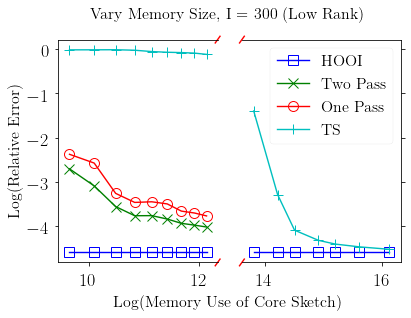

In [346]:
fig1_repplot(avg_sim_list(sim_fig1_lk), avg_sim_list(sim_fig1_lk_ext), ks = np.arange(12,30,2),Ks = Ks, gen_type = 'lk', name = 'fig1_lk.pdf',n =300)


<Figure size 432x360 with 0 Axes>

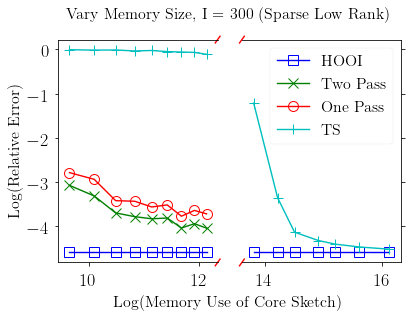

In [317]:
fig1_repplot(avg_sim_list(sim_fig1_slk), avg_sim_list(sim_fig1_slk_ext), ks = np.arange(12,30,2),Ks = Ks, gen_type = 'slk', name = 'fig1_slk.pdf',n =300)


<Figure size 432x360 with 0 Axes>

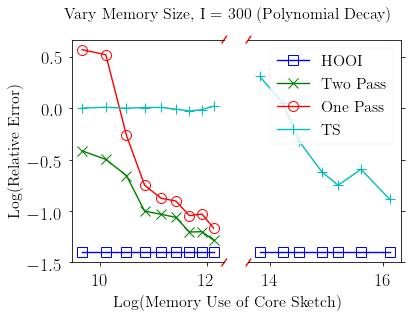

In [318]:
fig1_repplot(avg_sim_list(sim_fig1_spd), avg_sim_list(sim_fig1_spd_ext), ks = np.arange(12,30,2),Ks = Ks, gen_type = 'spd', name = 'fig1_spd.pdf',n =300)


In [72]:
pickle.dump(sim_fig1_spd, open("data/fig1_spd" +".pickle", "wb"))
pickle.dump(sim_fig1_lk, open("data/fig1_lk" +".pickle", "wb"))
pickle.dump(sim_fig1_slk, open("data/fig1_slk" +".pickle", "wb"))
pickle.dump(sim_fig1_lk_ext, open("data/fig1_lk_ext" +".pickle", "wb"))
pickle.dump(sim_fig1_slk_ext, open("data/fig1_slk_ext" +".pickle", "wb"))
pickle.dump(sim_fig1_spd_ext, open("data/fig1_spd_ext" +".pickle", "wb"))

# Fix r, Vary k setting

In [12]:
'''
def journal_nssimlog(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = []
    if outside: 
        plt.figure(figsize = (12,5))
    else: 
        plt.figure(figsize = (6,5))
    ymaxs = []
    ymins = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))        
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        two_pass_result = np.mean(sim_list[i][plot_id][0],0)  
        one_pass_result = np.mean(sim_list[i][plot_id][1],0)
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        two_pass_logratio = [np.log(two_pass_result[i]) for i in range(len(hosvd_result))]
        one_pass_logratio = [np.log(one_pass_result[i]) for i in range(len(hosvd_result))]
        plt.plot(ks/n, one_pass_logratio, label = find_rm_label(rm_typ), markersize = 10, marker = MARKER_LIST[i+1], markeredgewidth=1, markerfacecolor='None') 
        if i == len(rm_typs)-1: 
            plt.plot(ks/n, np.log(hosvd_result), label = 'HOOI', markersize = 10, marker = MARKER_LIST[0],markeredgewidth=1, markerfacecolor='None')
        alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
        ymaxs.append(max(alldata))
        ymins.append(min(alldata))    
    if gen_type in ['lk','slk']:
        plt.title("Vary k, I = %s"%(n)+" ("+find_gen_label(gen_type)+" $\gamma=$ "+str(noise_level)+")")
    else: 
        plt.title("Vary k, I = %s"%(n)+" ("+find_gen_label(gen_type)+")")

    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        leg = plt.legend(fontsize = fontsize, bbox_to_anchor=(1.7, 0.8))
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
    ymin = min(ymins) 
    ymax = max(ymaxs)  
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else:
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/journal/'+name)
    plt.show()
'''

IndentationError: unexpected indent (<ipython-input-12-2725b3ddd8bf>, line 4)

In [29]:
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_600.pdf",600, outside = True)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_400.pdf",400, outside = True)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_200.pdf",200, outside = True)

NameError: name 'journal_nssimlog' is not defined

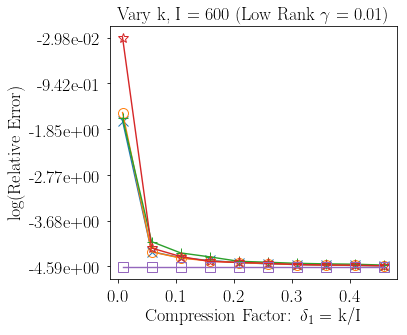

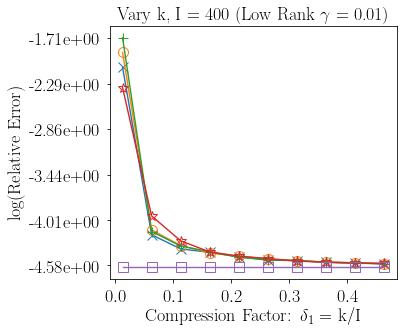

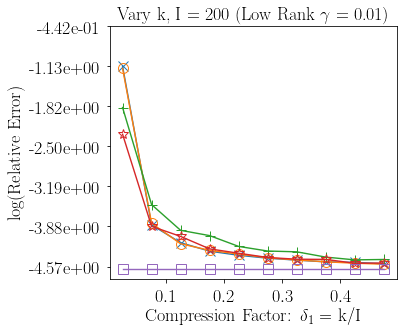

In [70]:
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_600.pdf",600)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_400.pdf",400)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_200.pdf",200)

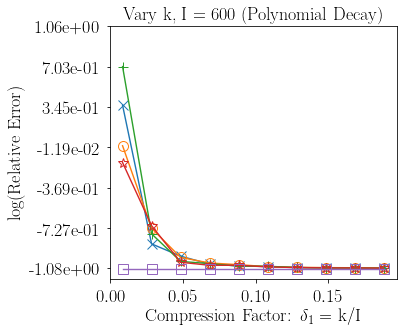

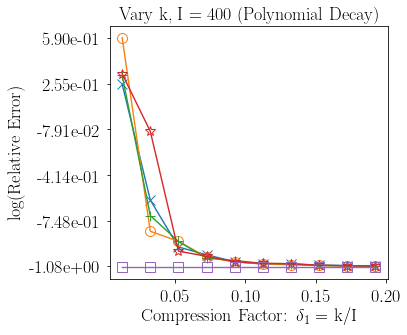

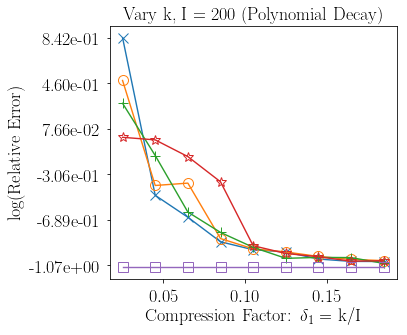

In [71]:
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_600.pdf",600)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_400.pdf",400)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_200.pdf",200)

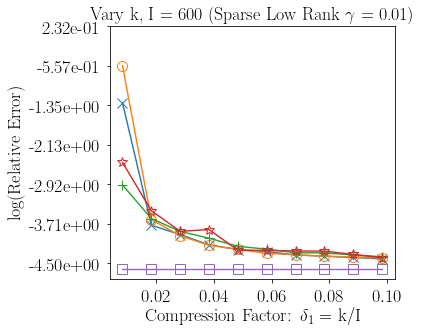

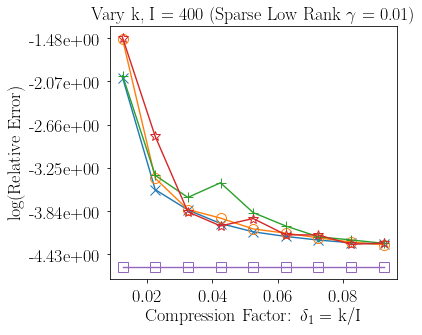

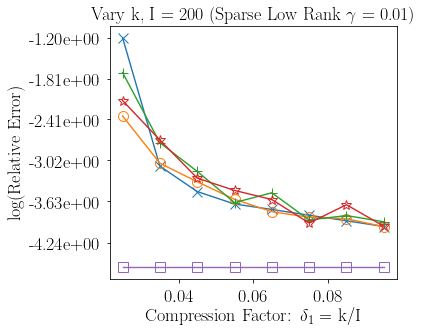

In [72]:
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_600.pdf",600)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_400.pdf",400)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_200.pdf",200)

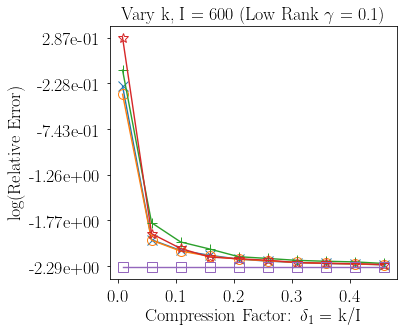

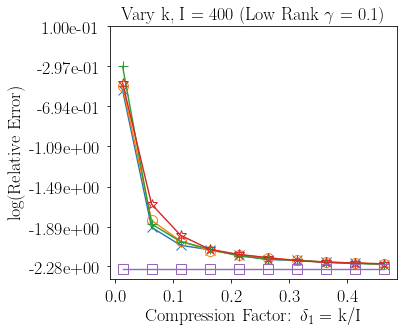

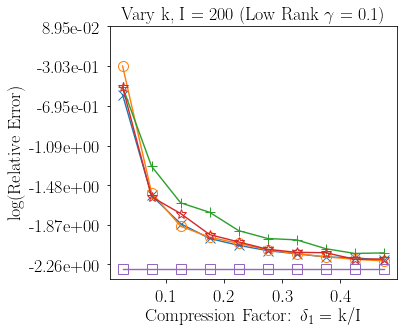

In [73]:
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_600.pdf",600)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_400.pdf",400)
journal_nssimlog(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_200.pdf",200)

In [51]:
def journal_nssim(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = []
    if outside: 
        plt.figure(figsize = (12,5))
    else: 
        plt.figure(figsize = (6,5))
    ymaxs = []
    ymins = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))        
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        two_pass_result_diff = np.mean(sim_list[i][plot_id][0],0) - hosvd_result
        one_pass_result_diff = np.mean(sim_list[i][plot_id][1],0) - hosvd_result
        plt.plot(ks/n, one_pass_result_diff, label = find_rm_label(rm_typ), markersize = 10, marker = marker('1pass', rm_typ), color = marker_color('1pass',rm_typ), markeredgewidth=1, markerfacecolor='None') 
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")")
    else: 
        plt.title(find_gen_label(gen_type))
    # plt.legend(loc = 'best', fontsize = fontsize)
    plt.yscale('log')
    if outside: 
        leg = plt.legend(fontsize = fontsize, bbox_to_anchor=(1.7, 0.8))
    plt.xlabel('k/I')
    plt.ylabel('Regret')  
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/journal/'+name)
    plt.show()

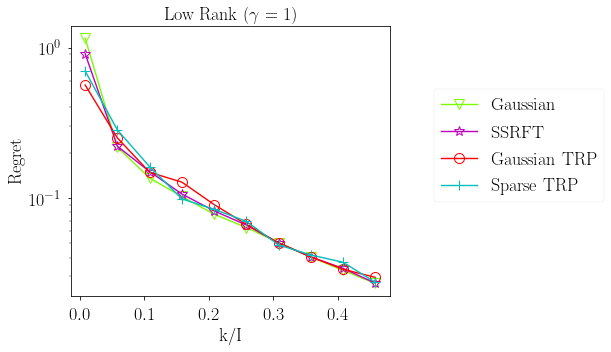

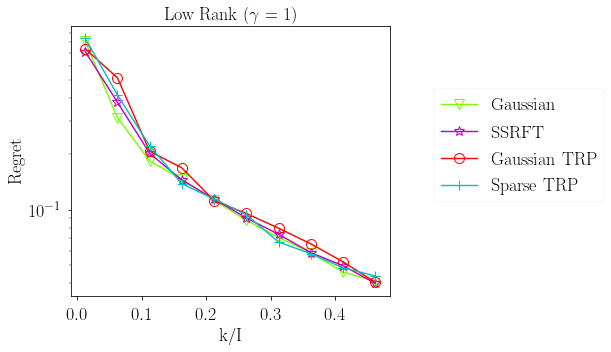

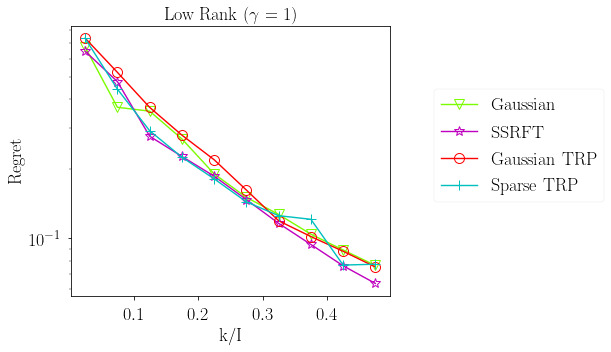

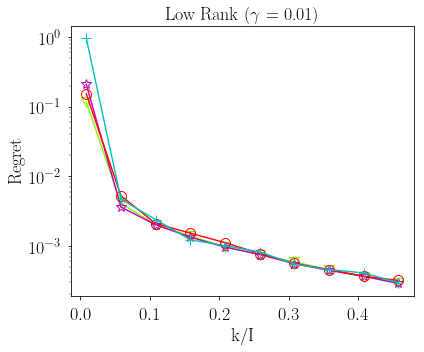

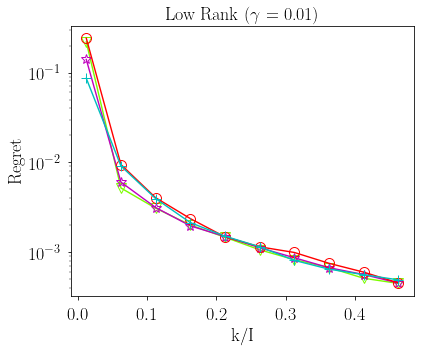

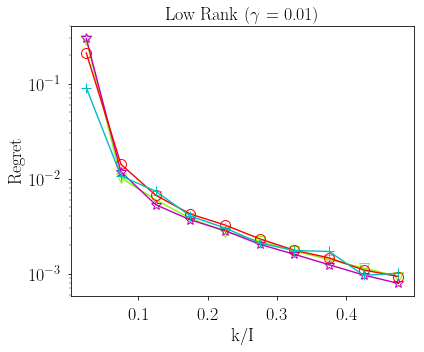

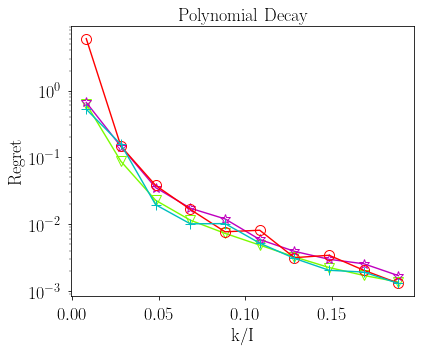

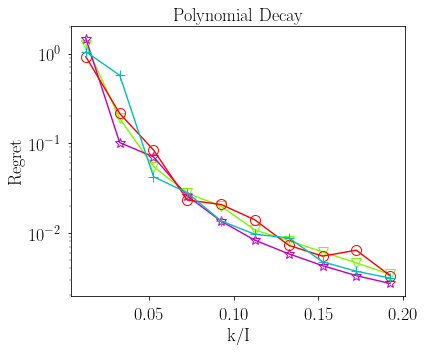

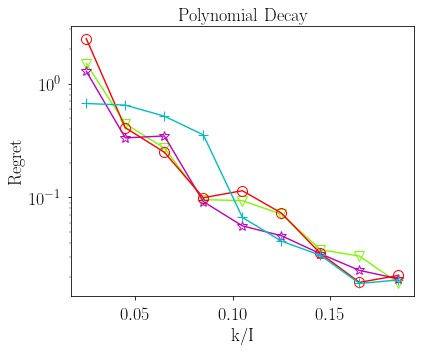

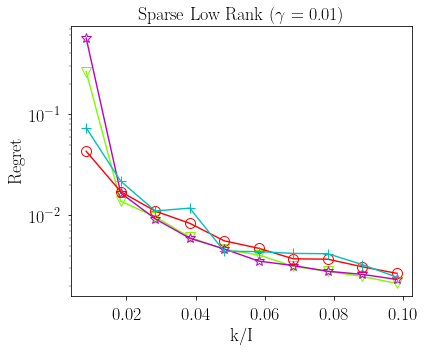

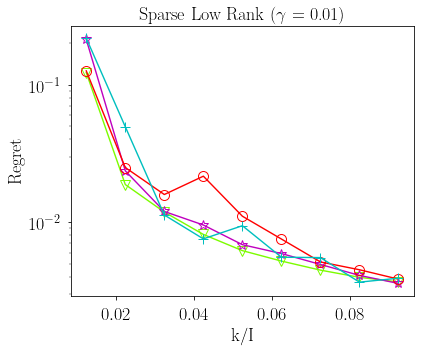

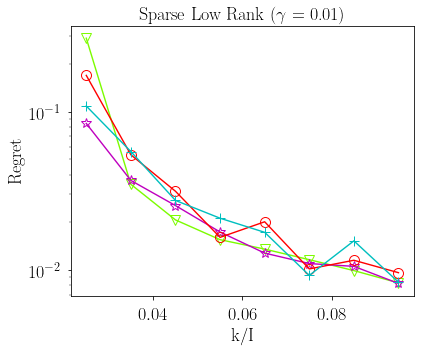

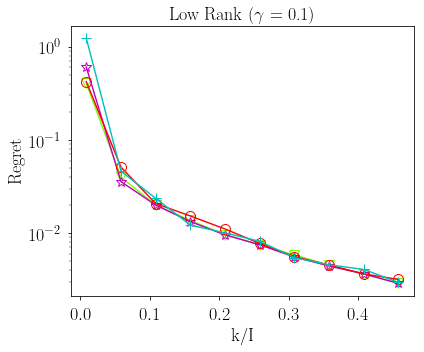

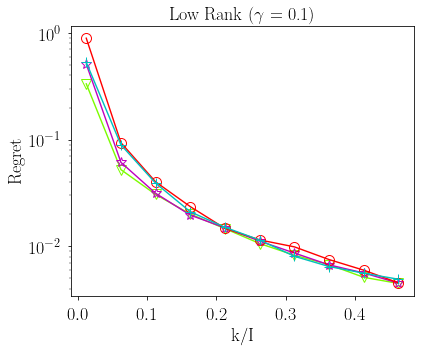

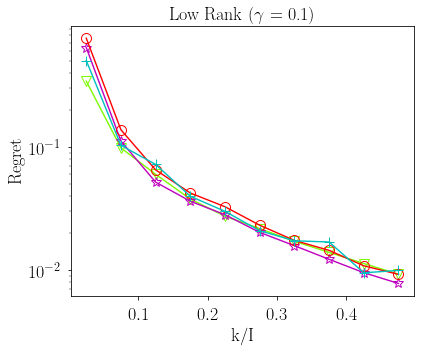

In [54]:
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_600.pdf",600, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_400.pdf",400, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_200.pdf",200, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_200.pdf",200)

In [55]:
'''
def journal_nssimlog2(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = []
    if outside: 
        plt.figure(figsize = (19,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    ymins = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        two_pass_result = np.mean(sim_list[i][plot_id][0],0)  
        one_pass_result = np.mean(sim_list[i][plot_id][1],0)
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        two_pass_logratio = [np.log(two_pass_result[i]) for i in range(len(hosvd_result))]
        one_pass_logratio = [np.log(one_pass_result[i]) for i in range(len(hosvd_result))]
        plt.plot(ks/n, one_pass_logratio, label = find_rm_label(rm_typ)+" 1-Pass", markersize = 10, marker = MARKER_LIST[i+1], markeredgewidth=1, markerfacecolor='None') 
        plt.plot(ks/n, two_pass_logratio, label = find_rm_label(rm_typ)+" 2-Pass", markersize = 10, marker = MARKER_LIST[i+1], markeredgewidth=1, markerfacecolor='None') 
        if i == len(rm_typs) -1 : 
            plt.plot(ks/n, np.log(hosvd_result), label = 'HOOI', markersize = 10, marker = MARKER_LIST[0],markeredgewidth=1, markerfacecolor='None')
        alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
        ymaxs.append(max(alldata))
        ymins.append(min(alldata))
    if gen_type in ['lk','slk']:
        plt.title("Vary k, I = %s"%(n)+" ("+find_gen_label(gen_type)+" $\gamma=$ "+str(noise_level)+")")
    else: 
        plt.title("Vary k, I = %s"%(n)+" ("+find_gen_label(gen_type)+")")


    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1.9, 0.85))
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
    ymin = min(ymins) 
    ymax = max(ymaxs)  
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else:
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/journal/'+name)
    plt.show()
    
'''

IndentationError: unexpected indent (<ipython-input-55-c946de32e25a>, line 4)

In [ ]:
journal_nssimlog2(['g','gprod'], 'lk',5,1,"fig3_lk_hnoise_600.pdf",600, outside = True)
journal_nssimlog2(['g','gprod'], 'lk',5,1,"fig3_lk_hnoise_400.pdf",400, outside = True)
journal_nssimlog2(['g','gprod'], 'lk',5,1,"fig3_lk_hnoise_200.pdf",200, outside = True)

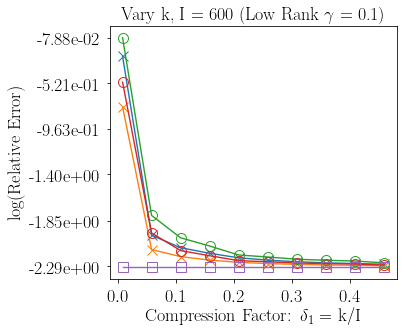

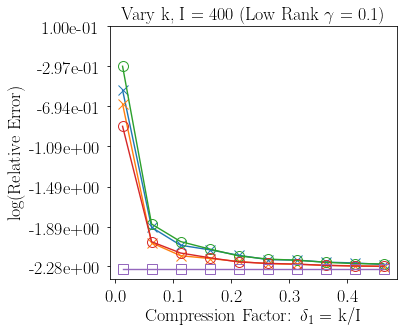

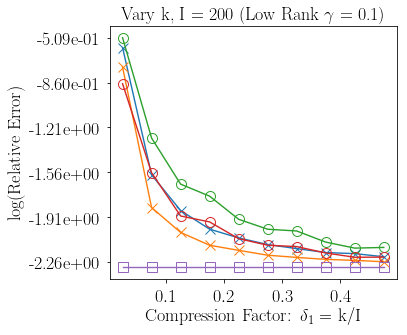

In [114]:
journal_nssimlog2(['g','gprod'], 'lk',5,0.1,"fig3_lk_mnoise_600.pdf",600)
journal_nssimlog2(['g','gprod'], 'lk',5,0.1,"fig3_lk_mnoise_400.pdf",400)
journal_nssimlog2(['g','gprod'], 'lk',5,0.1,"fig3_lk_mnoise_200.pdf",200)

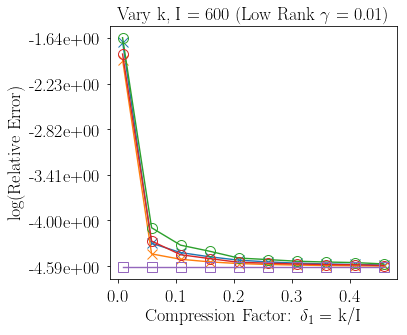

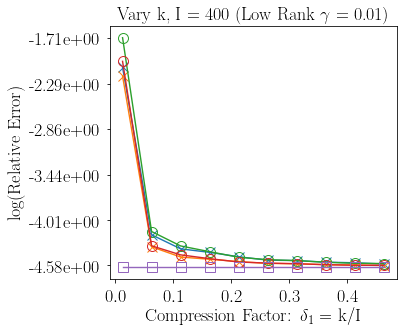

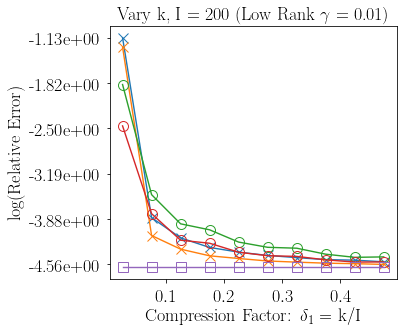

In [115]:
journal_nssimlog2(['g','gprod'], 'lk',5,0.01,"fig3_lk_lnoise_600.pdf",600)
journal_nssimlog2(['g','gprod'], 'lk',5,0.01,"fig3_lk_lnoise_400.pdf",400)
journal_nssimlog2(['g','gprod'], 'lk',5,0.01,"fig3_lk_lnoise_200.pdf",200)

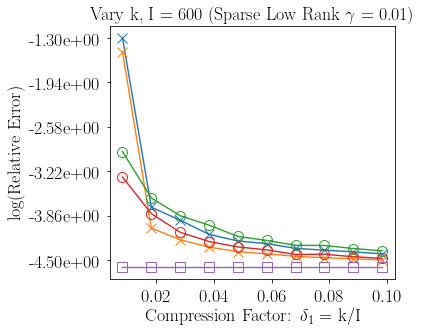

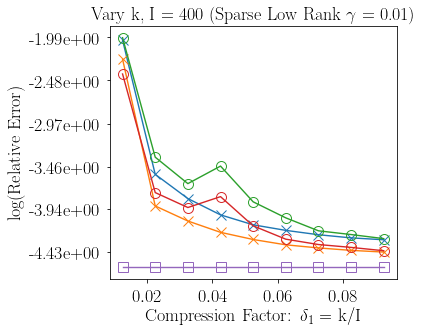

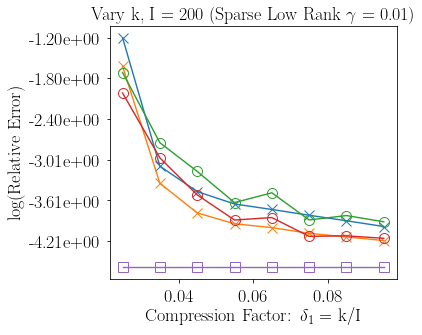

In [116]:
journal_nssimlog2(['g','gprod'], 'slk',5,0.01,"fig3_slk_lnoise_600.pdf",600)
journal_nssimlog2(['g','gprod'], 'slk',5,0.01,"fig3_slk_lnoise_400.pdf",400)
journal_nssimlog2(['g','gprod'], 'slk',5,0.01,"fig3_slk_lnoise_200.pdf",200)

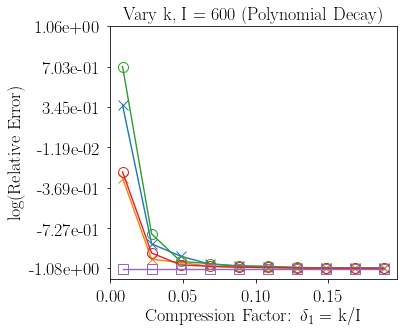

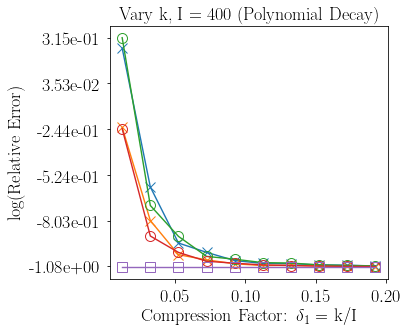

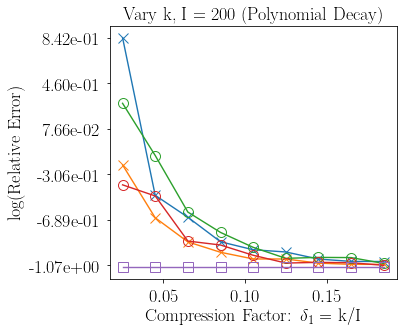

In [117]:
journal_nssimlog2(['g','gprod'], 'spd',5,0.01,"fig3_spd_600.pdf",600)
journal_nssimlog2(['g','gprod'], 'spd',5,0.01,"fig3_spd_400.pdf",400)
journal_nssimlog2(['g','gprod'], 'spd',5,0.01,"fig3_spd_200.pdf",200)

In [ ]:
def journal_nssim2(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = []
    if outside: 
        plt.figure(figsize = (19,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    ymins = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        two_pass_result_diff = np.mean(sim_list[i][plot_id][0],0) - hosvd_result
        one_pass_result_diff = np.mean(sim_list[i][plot_id][1],0) - hosvd_result
        plt.plot(ks/n, one_pass_result_diff, label = find_rm_label(rm_typ)+" 1-Pass", markersize = 10, marker = marker('1pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
        plt.plot(ks/n, two_pass_result_diff, label = find_rm_label(rm_typ)+" 2-Pass", markersize = 10, marker = marker('2pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")")
    else: 
        plt.title(find_gen_label(gen_type))

    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1.9, 0.85))
    plt.yscale('log')
    plt.xlabel('k/I')
    plt.ylabel('Regret')
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/journal/'+name)
    plt.show()

In [ ]:
journal_nssim2(['gprod'], 'lk',5,1,"fig3_lk_hnoise_600.pdf",600, outside = True)
journal_nssim2(['gprod'], 'lk',5,1,"fig3_lk_hnoise_400.pdf",400, outside = True)
journal_nssim2(['gprod'], 'lk',5,1,"fig3_lk_hnoise_200.pdf",200, outside = True)
journal_nssim2(['gprod'], 'lk',5,0.1,"fig3_lk_mnoise_600.pdf",600)
journal_nssim2(['gprod'], 'lk',5,0.1,"fig3_lk_mnoise_400.pdf",400)
journal_nssim2(['gprod'], 'lk',5,0.1,"fig3_lk_mnoise_200.pdf",200)
journal_nssim2(['gprod'], 'lk',5,0.01,"fig3_lk_lnoise_600.pdf",600)
journal_nssim2(['gprod'], 'lk',5,0.01,"fig3_lk_lnoise_400.pdf",400)
journal_nssim2(['gprod'], 'lk',5,0.01,"fig3_lk_lnoise_200.pdf",200)
journal_nssim2(['gprod'], 'slk',5,0.01,"fig3_slk_lnoise_600.pdf",600)
journal_nssim2(['gprod'], 'slk',5,0.01,"fig3_slk_lnoise_400.pdf",400)
journal_nssim2(['gprod'], 'slk',5,0.01,"fig3_slk_lnoise_200.pdf",200)
journal_nssim2(['gprod'], 'spd',5,0.01,"fig3_spd_600.pdf",600)
journal_nssim2(['gprod'], 'spd',5,0.01,"fig3_spd_400.pdf",400)
journal_nssim2(['gprod'], 'spd',5,0.01,"fig3_spd_200.pdf",200)

# Implementation actually problematic: the code needs to aggregate multiple runs

# Speed comparison

In [36]:
def journal_nssim_time(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, outside = False, ONE_PASS = True, TWO_PASS = True): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    if outside: 
        plt.figure(figsize = (19,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    ymins = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_time = pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+"_time.pickle", "rb" ) )
        sim_acc = pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) )
        plot_id = ns.index(n)
        
        if rm_typ == 'gprod':
            hosvd_acc = np.mean(sim_acc[plot_id][2],0)[0]
            hosvd_time = np.mean(sim_time[1][plot_id][2],0)[0]
            plt.plot(hosvd_time, hosvd_acc, label = "HOOI", markersize = 10, marker = marker('hooi', rm_typ), markeredgewidth=1, markerfacecolor='None') 

        two_pass_acc = [np.mean(sim_acc[plot_id][1],0)[i]  for i in [1,3,7]]
        two_pass_time = [(np.mean(sim_time[0][plot_id][0],0)+np.mean(sim_time[1][plot_id][0],0))[i] for i in [1,3,7]]
        
        one_pass_acc = [np.mean(sim_acc[plot_id][0],0)[i] for i in [1,3,7]]
        one_pass_time = [(np.mean(sim_time[0][plot_id][1],0)+np.mean(sim_time[1][plot_id][1],0))[i] for i in [1,3,7]]
        if ONE_PASS: 
            # Sort the output: 
            list1, list2 = zip(*sorted(zip(one_pass_time,one_pass_acc)))
            plt.plot(list1, list2, label = find_rm_label(rm_typ)+" 1-Pass", markersize = 10, marker = marker('1pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
        if TWO_PASS:
            list1, list2 = zip(*sorted(zip(two_pass_time,two_pass_acc)))
            plt.plot(list1, list2, label = find_rm_label(rm_typ)+" 2-Pass", markersize = 10, marker = marker('2pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1.9, 0.85))
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")")
    else: 
        plt.title(find_gen_label(gen_type))   
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Error')
    plt.minorticks_on()
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/journal/'+name,bbox_inches='tight')
    plt.show()

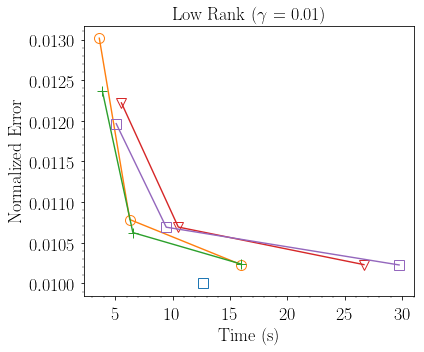

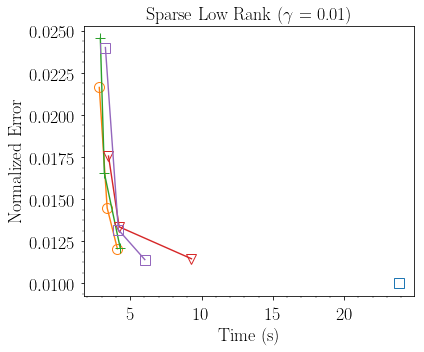

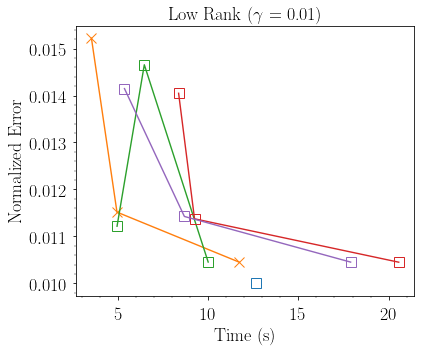

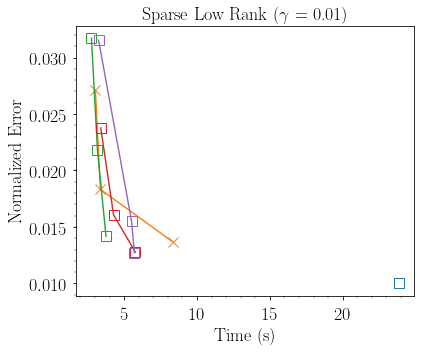

In [37]:
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'lk',5,0.01,"lk_1pass_time.pdf",600, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'slk',5,0.01,"slk_1pass_time.pdf",600, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'lk',5,0.01,"lk_2pass_time.pdf",600, ONE_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'slk',5,0.01,"slk_2pass_time.pdf",600, ONE_PASS=False)

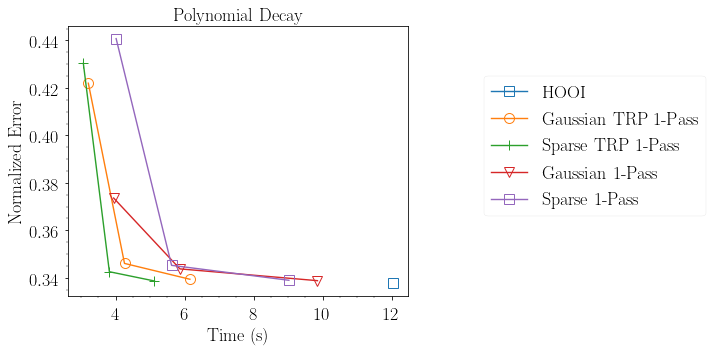

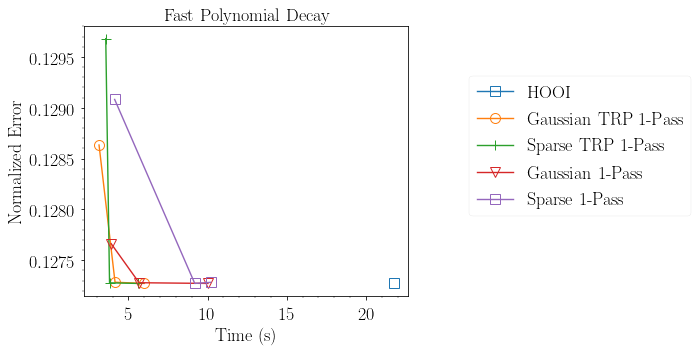

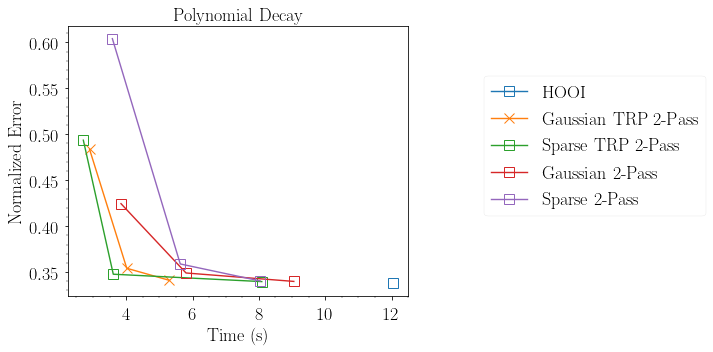

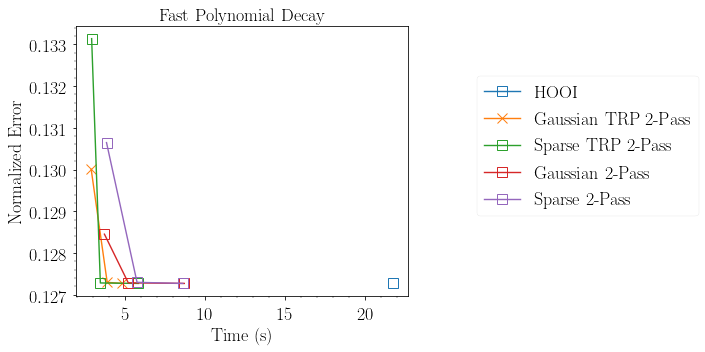

In [38]:
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'spd',5,0.01,"spd_1pass_time.pdf",600, outside = True, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'fpd',5,0.01,"fpd_1pass_time.pdf",600, outside = True, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'spd',5,0.01,"spd_2pass_time.pdf",600, outside = True, ONE_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'fpd',5,0.01,"fpd_2pass_time.pdf",600, outside = True, ONE_PASS=False)

# Why ssrft is super-slow

In [69]:
import time
def ssrft(k,X, seed = 1, mult = "right"):
    start_time = time.time()
    np.random.seed(seed)
    m, n = X.shape 
    if mult == "left": 
        perm1 = np.random.permutation(m) 
        perm2 = np.random.permutation(m)  
        coord = np.random.permutation(m)[0:k] 
        sign1 = np.random.choice([-1, 1], size = m)
        sign2 = np.random.choice([-1, 1], size = m) 
        result = fftpack.dct(sign1.reshape(m,1)*X[perm1,:])
        result = fftpack.dct(sign2.reshape(m,1)*result[perm2,:])
        return result[coord,:]
    if mult == "right": 
        print(time.time() - start_time)
        perm1 = np.random.permutation(n) 
        print(time.time() - start_time)
        perm2 = np.random.permutation(n)  
        print(time.time() - start_time)
        coord = np.random.permutation(n)[0:k] 
        print(time.time() - start_time)
        sign1 = np.random.choice([-1, 1], size = n)
        print(time.time() - start_time)
        sign2 = np.random.choice([-1, 1], size = n) 
        print(time.time() - start_time)
        result = fftpack.dct(X[:, perm1]*sign1.reshape(1,n), axis = 1) 
        print(time.time() - start_time)
        result = fftpack.dct(result[:, perm2]*sign2.reshape(1,n), axis = 1)
        print(time.time() - start_time)
        return result[:,coord]

In [66]:
X = np.random.random( size = [10000,10000]) 

In [67]:
k = 10

In [68]:
ssrft(k,X)

1.0013580322265625e-05
0.0022149085998535156
0.002476215362548828
0.002794027328491211
0.0038459300994873047
0.004766941070556641
5.72137713432312
11.224113941192627


array([[  2822.86510019,  -6966.89606245, -17226.36649622, ...,
          8151.26930609,   1463.15540689,  -5993.8313543 ],
       [ -4089.06881537,  13827.28789814, -14845.28874138, ...,
         22994.5539868 ,   4064.78405124,   6260.20748545],
       [  -959.35511242,   2699.3487899 , -11049.99387513, ...,
         14523.27689017,    426.84365639,  15142.28448681],
       ...,
       [  4939.56147345,  -7585.22181627, -12246.62162864, ...,
         22332.80454946,  -7412.5677569 ,  16932.23066088],
       [  4110.98920964,  12224.4397081 , -13772.12789481, ...,
         26426.45777712,  -5319.00222301,   4524.57279763],
       [  2046.41869274,   2468.78353497, -14056.39723145, ...,
         22754.07330294,  -9503.82063403,   1699.88280664]])

# Current observation: the dct step from numpy is super-slow